In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.base import clone
from cross_val import *
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [4]:
def plotNumbers(X, y):
    _, axes = plt.subplots(nrows=1, ncols=len(y), figsize=(10, 3))

    for ax, image, label in zip(axes, X, y):
        ax.set_axis_off()
        ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("Training: %s" % str(label))

def plot_confusion_matrix(predicted, y):
    cm = confusion_matrix(y, predicted)
    cmp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(10,10))
    cmp.plot(ax=ax)

In [5]:
print(X.shape)

(70000, 784)


In [6]:
train_samples = 20000

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_samples, test_size=5000)

In [7]:
X_train[:] = 255 - X_train[:]
X_val[:] = 255 - X_val[:]

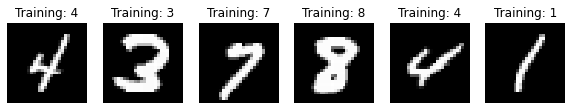

In [8]:
#print(X_train[0])
plotNumbers(X_train[:6], y_train[:6])

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_val)

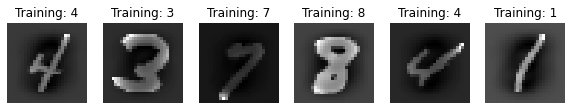

In [10]:
plotNumbers(X_train_scaled[:6], y_train[:6])

In [11]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(),
    DecisionTreeClassifier(max_depth=5),
    LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1),
    LinearRegression()
]

In [12]:
def checkClassifier(clf, X_train, y_train, X_val, y_val):
    trained_clf, accuracy_list = cross_val(clf, X_train, y_train, 5)

    print(accuracy_list)

    best_clf = trained_clf[np.argmax(accuracy_list)]
    Z = best_clf.predict(X_val)
    accuracy = accuracy_score(y_val, Z)

    print("Best classifier performance %.4f" %  accuracy)

    return best_clf

In [15]:
def testOnDataset(clf, X_train, y_train, X_val, y_val):
    best_clf = checkClassifier(clf, X_train, y_train, X_val, y_val)
    Z = best_clf.predict(X_val)
    plot_confusion_matrix(y_val, Z)

    wrong_predictions = [i for i in np.arange(len(Z)) if Z[i] != y_val[i]]
    plotNumbers(X_val[wrong_predictions][:8], Z[wrong_predictions][:8])

<h1>KNN</h1>

[0.95725, 0.95975, 0.95775, 0.9545, 0.9545]
Best classifier performance 0.9534


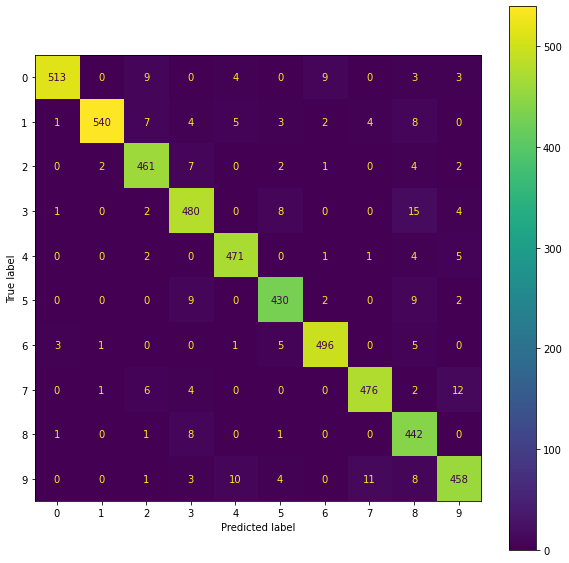

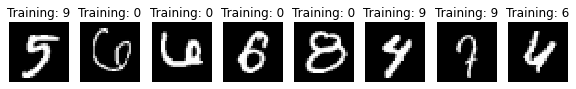

In [16]:
testOnDataset(classifiers[0], X_train, y_train, X_val, y_val)

[0.92225, 0.927, 0.918, 0.9235, 0.919]
Best classifier performance 0.9244


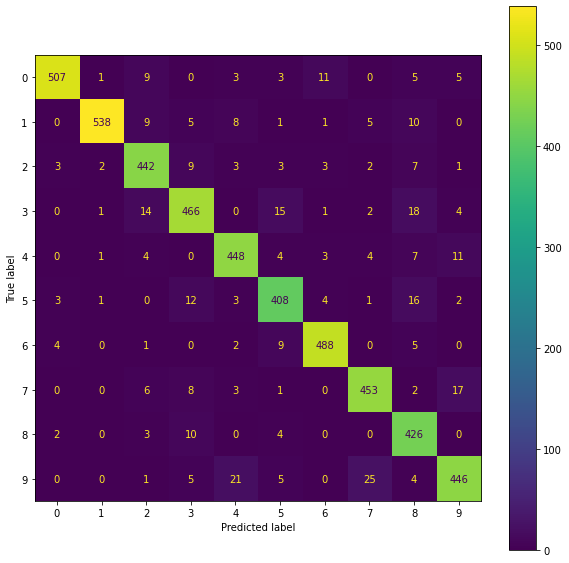

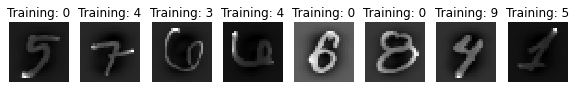

In [17]:
testOnDataset(classifiers[0], X_train_scaled, y_train, X_test_scaled, y_val)

<h1>SVM</h1>

[0.9665, 0.964, 0.96625, 0.9635, 0.964]
Best classifier performance 0.9666


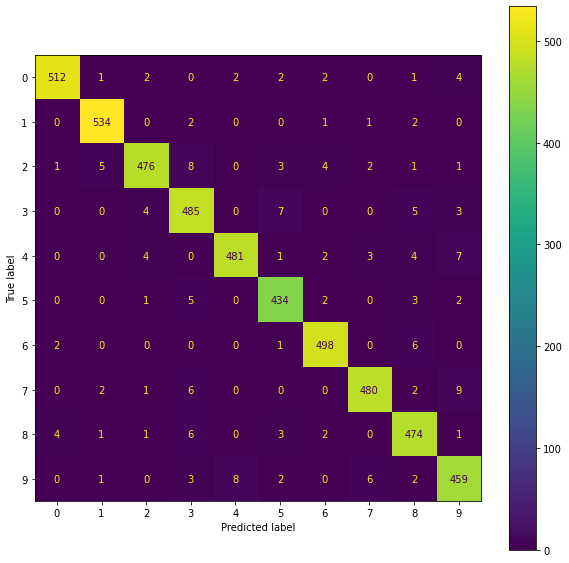

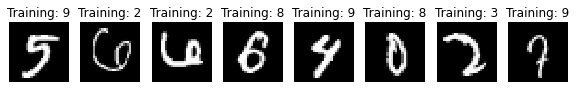

In [18]:
testOnDataset(classifiers[1], X_train, y_train, X_val, y_val)

[0.946, 0.94625, 0.94525, 0.945, 0.93625]
Best classifier performance 0.9414


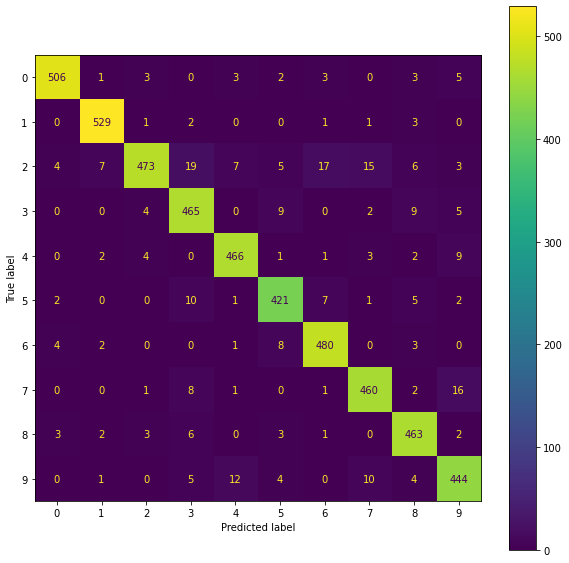

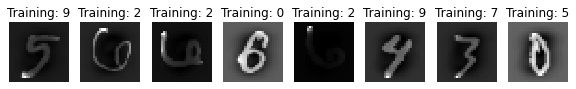

In [19]:
testOnDataset(classifiers[1], X_train_scaled, y_train, X_test_scaled, y_val)

<h1>Decision Tree</h1>

[0.65975, 0.68325, 0.6885, 0.66325, 0.6675]
Best classifier performance 0.6792


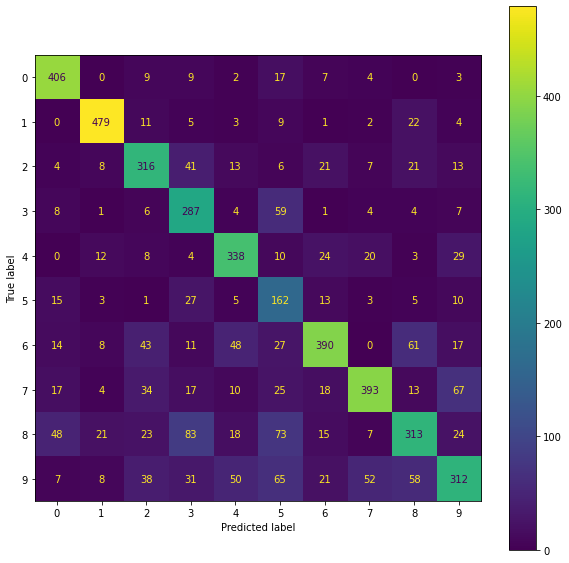

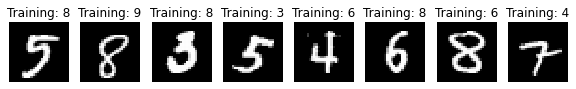

In [20]:
testOnDataset(classifiers[2], X_train, y_train, X_val, y_val)

[0.65975, 0.68325, 0.6885, 0.66375, 0.6675]
Best classifier performance 0.6792


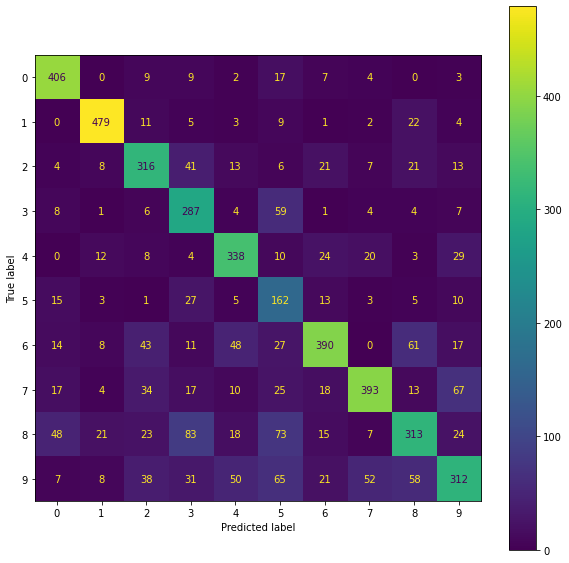

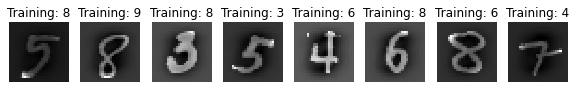

In [21]:
testOnDataset(classifiers[2], X_train_scaled, y_train, X_test_scaled, y_val)

<h1>Logistic regression</h1>

[0.9025, 0.90475, 0.90725, 0.88575, 0.9]
Best classifier performance 0.9010


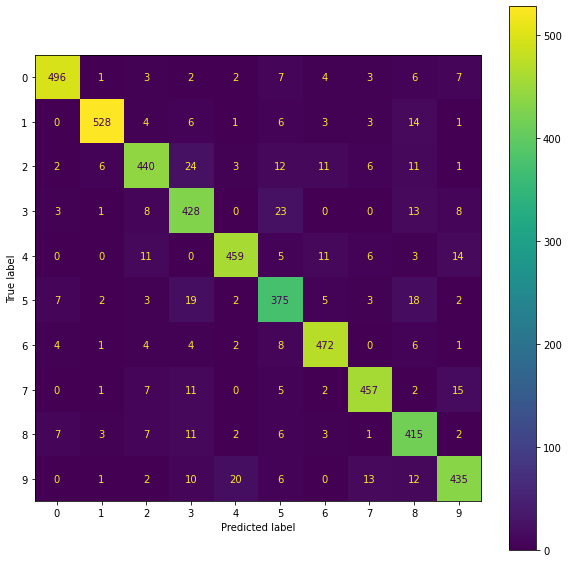

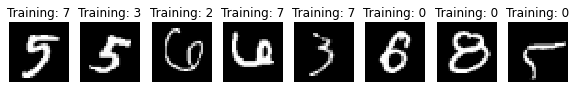

In [22]:
testOnDataset(classifiers[3], X_train, y_train, X_val, y_val)

[0.8065, 0.82675, 0.8315, 0.81025, 0.8205]
Best classifier performance 0.8236


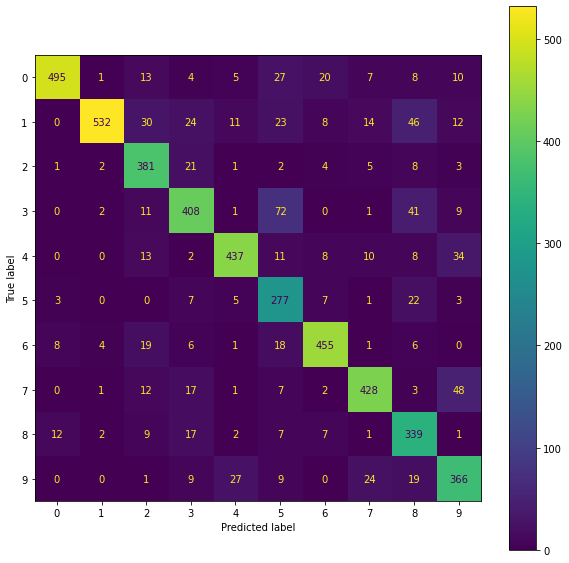

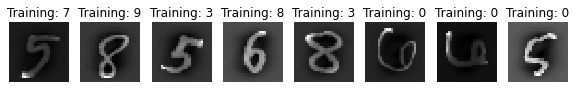

In [23]:
testOnDataset(classifiers[3], X_train_scaled, y_train, X_test_scaled, y_val)

<h1>Веса</h1>
<h3>По модулю, чтобы +-0 был около 0, иначе он выглядит серым</h3>

In [26]:
best_clf = checkClassifier(classifiers[3], X_train, y_train, X_val, y_val)

[0.9025, 0.90025, 0.896, 0.89325, 0.9005]
Best classifier performance 0.9020


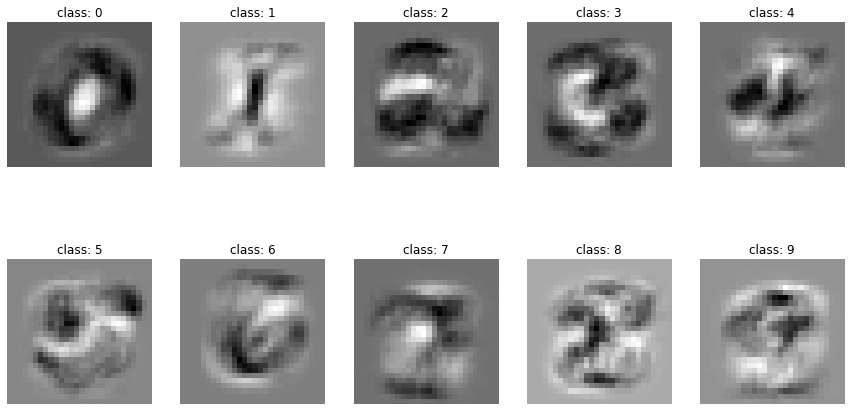

In [28]:
#plotNumbers(best_clf.coef_[:], best_clf.classes_)
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))

for ax, image, label in zip(axes.reshape(-1), best_clf.coef_, best_clf.classes_):
    ax.set_axis_off()
    ax.imshow(np.real(image.reshape((28, 28))), cmap=plt.cm.gray, interpolation="nearest")
    ax.set_title("class: %s" % str(label))

In [29]:
print(best_clf.coef_.min(), best_clf.coef_.max())

-0.002162682129693303 0.0020936858569778724


<h2>Занулим всё ниже некоторого порога</h2>

In [30]:
from copy import deepcopy

thresholds = [1e-3, 1e-4, 0.5e-4, 1e-5, 1e-6]
for threshold in thresholds:
    clf_test = deepcopy (best_clf)
    clf_test.coef_[np.abs(clf_test.coef_[:][:]) < threshold] = 0

    Z = clf_test.predict(X_val)
    accuracy = accuracy_score(y_val, Z)
    print("accuracy with threshold: ", threshold, " = ", accuracy)

accuracy with threshold:  0.001  =  0.3458
accuracy with threshold:  0.0001  =  0.7008
accuracy with threshold:  5e-05  =  0.8414
accuracy with threshold:  1e-05  =  0.9022
accuracy with threshold:  1e-06  =  0.902


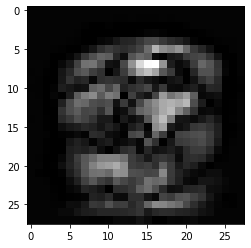

In [31]:
mask = np.ones_like(clf_test.coef_[0])
for i in range(clf_test.coef_.shape[0]):
    mask = np.inner(mask, clf_test.coef_[i])

plt.imshow(np.abs(mask.reshape((28, 28))), cmap=plt.cm.gray, interpolation="nearest")
plt.show()